## TPE vs SNR scenario in the stationary case

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scienceplots
plt.style.use(['science', 'grid'])
plt.rcParams['text.usetex'] = True

In [2]:
df = pd.read_csv('data/TEP_vs_SNR.csv')

In [3]:
# Random choice of SNR
snr_name = np.random.choice(df.columns[1:])
snr = float(snr_name)

print(f"Selected SNR : {snr} dB")

Selected SNR : -3.0 dB


In [4]:
# TEP and bitrates for each modulation method
tep_values = df[snr_name].values
bitrates = np.array([2520, 840, 360, 168])

In [5]:
def get_action(Q, eps):
    """Perform an epsilon-greedy action selection.

    Parameters
    ----------
    Q: array-like
        Estimated action values
    eps: float
        Probability of selecting a non-greedy action instead of the greedy one

    Returns
    -------
    a: int
        An action
    """
    if np.random.random() <= eps:
        a = np.random.randint(Q.size)
    else:
        a = np.argmax(Q)
    return a

In [6]:
def get_reward(bitrates, tep_values, a):
    """Return a reward according to the selected action and the data.

    Parameters
    ----------
    bitrates: array-like
        The bitrates
    tep_values: array-like
        The error rates
    a: int
        The selected action

    Returns
    -------
    R: float
        A reward 
    """
    if np.random.random() < tep_values[a]:
        R = 0 # Non-transmitted packet
    else:
        R = bitrates[a]
    return R 

In [7]:
def fit_total_reward(bitrates, tep_values, n_iter=1000, eps=0.05):
    """Train the agent using incrementally computed sample averages and
    epsilon-greedy action selection.

    Parameters
    ----------
    bitrates: array-like
        Bitrate (in bits/s) of each modulation method
    tep_values: array-like
        TEP values of each modulation method
    n_iter: int, default 100
        Number of iterations
    eps: float, default 0.05
        Probability of selecting a non-greedy action instead of the greedy one

    Returns
    -------
    total_reward: float
        The total reward. It is the sum of the bitrates used during the run.
    """
    k = bitrates.size # Number of actions ie number of modulation methods
    Q = np.zeros(k) # Estimated action values
    N = np.zeros(k) # Number of times each action was chosen
    total_reward = 0
    
    for _ in range(n_iter):
        # Select an action and add the corresponding reward
        a = get_action(Q, eps)
        R = get_reward(bitrates, tep_values, a)
        total_reward += R

        # Update of action value using sample-average method
        N[a] += 1
        Q[a] += (R - Q[a]) / N[a]

    return total_reward

### Influence of $\varepsilon$ on the total reward

In [8]:
# Experience parameters
n_iter = 10000
eps_range = np.linspace(0, 1, num=100)
total_rewards = np.array([])

In [9]:
# Compute the total reward for each epsilon

for eps in eps_range:
    total_reward = fit_total_reward(bitrates, tep_values, n_iter, eps)
    total_rewards = np.concatenate((total_rewards, np.array([total_reward])))

total_rewards /= np.max(total_rewards)

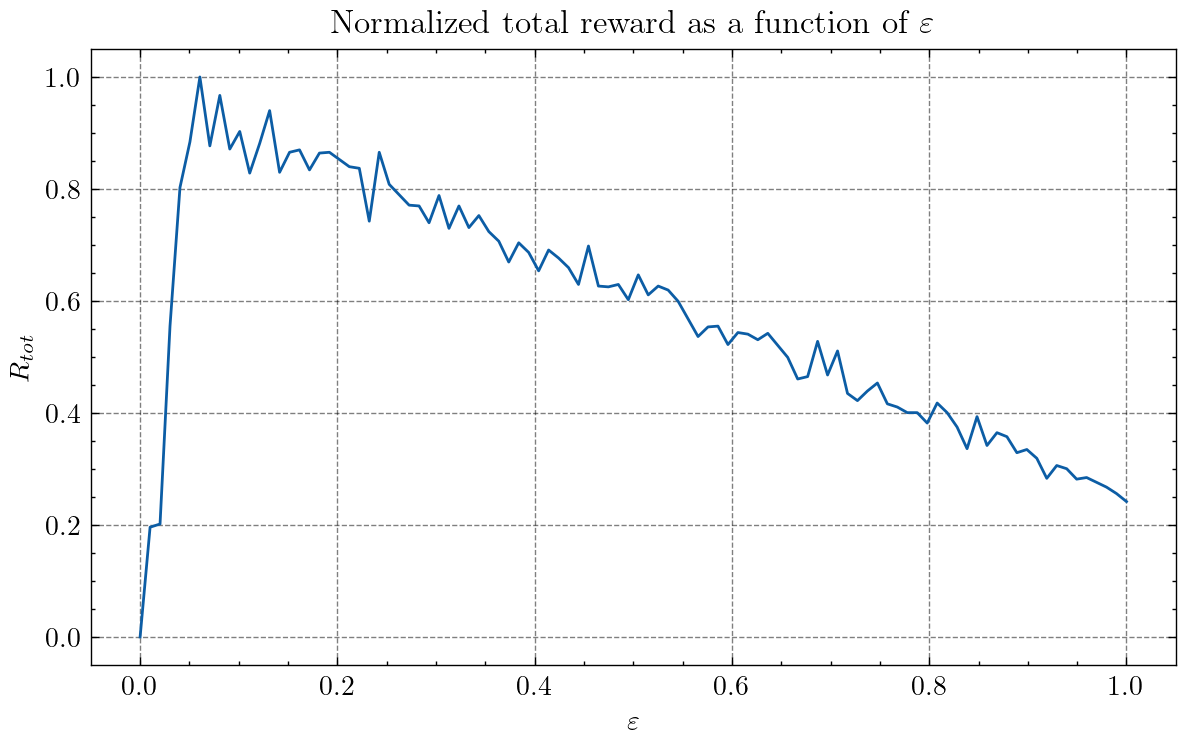

In [10]:
# Plot total_reward = f(epsilon)

plt.figure(figsize=(7,4), dpi=200)
plt.plot(eps_range, total_rewards)
plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'$R_{tot}$')
plt.title(r'Normalized total reward as a function of $\varepsilon$')
plt.show()

In [11]:
print(f"Optimal computed epsilon: {eps_range[np.argmax(total_rewards)]:.3f}")

Optimal computed epsilon: 0.061


**Observations:**
- Neither the greedy selection method (i.e. $\varepsilon=0$) nor the random selection method (i.e. $\varepsilon=1$) are the optimal ones. A small value of $\varepsilon$ like $\varepsilon=0.05$ leads to better results in terms of total reward.
- Because of the absence of exploration, the greedy action selection method seems worse than the random one.
- The overall trend shows that total reward decreases as $\varepsilon$ increases. So it seems that exploration should be restricted and negligible compared to exploitation.

### Experience on the average reward

In [29]:
def fit_mean_rewards(bitrates, tep_values, n_agents=1000, n_iter=1000, eps=0.05):
    """Train the agent using incrementally computed sample averages and
    epsilon-greedy action selection.

    Parameters
    ----------
    bitrates: array-like
        Bitrate (in bits/s) of each modulation method
    tep_values: array-like
        TEP values of each modulation method
    n_iter: int, default 1000
        Number of time steps
    n_agent: int, default 1000
        Number of agents
    eps: float, default 0.05
        Probability of selecting a non-greedy action instead of the greedy one

    Returns
    -------
    mean_rewards: list(float)
        Mean reward at each time step
    """
    k = bitrates.size # Number of actions ie number of modulation methods
    Q = np.zeros((n_agents, k)) # Estimated action values for each agent
    N = np.zeros((n_agents, k)) # Number of action selections for each agent
    mean_rewards = list()
    
    for _ in range(n_iter):
        mean_R = 0
        for i in range(n_agents):
            # Update the action values of agent i using sample-average method
            a = get_action(Q[i,:], eps)
            R = get_reward(bitrates, tep_values, a)
            N[i, a] += 1
            Q[i, a] += (R - Q[i, a]) / N[i, a]

            # Update the mean reward
            mean_R += R
        mean_R /= n_agents
        mean_rewards.append(mean_R)

    return mean_rewards

In [38]:
# Compute the mean rewards for different epsilons
epsilons = [1e-2, 1e-1, 0.95]
all_mean_rewards = list()

for eps in epsilons:
    all_mean_rewards.append(fit_mean_rewards(bitrates, tep_values, n_agents=2000, n_iter=1000, eps=eps))

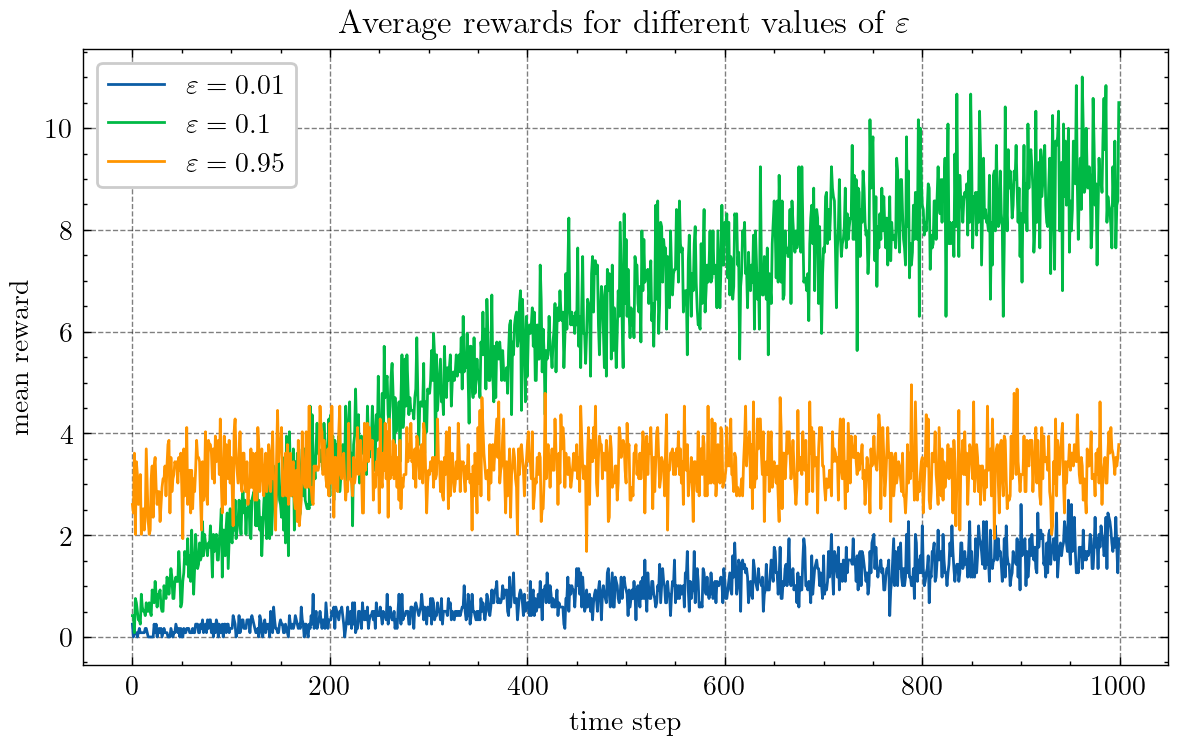

In [44]:
plt.figure(figsize=(7,4), dpi=200)
plt.plot(all_mean_rewards[0], label=r'$\varepsilon=0.01$')
plt.plot(all_mean_rewards[1], label=r'$\varepsilon=0.1$')
plt.plot(all_mean_rewards[2], label=r'$\varepsilon=0.95$')
plt.title(r'Average rewards for different values of $\varepsilon$')
plt.xlabel('time step')
plt.ylabel('mean reward')
plt.legend()
plt.show()